In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
x_train = np.load('../exam2_train_x.npy')
y_train = np.load('../exam2_train_y.npy')
x_test = np.load('../exam2_test_x.npy')
y_test = np.load('../exam2_test_y.npy')

In [3]:
x_train_norm = (x_train / 255.) - 0.5
x_test_norm = (x_test / 255.) - 0.5
x_train_norm_1 = (x_train/255.)
x_test_norm_1 = (x_test/255.)

In [4]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    keep_prob= tf.placeholder(tf.float32)
    return X, Y, keep_prob

In [5]:
def initialize_parameters():

    
    tf.set_random_seed(1)                             
        
    W1 = tf.get_variable("W1", [2, 2, 3, 32], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    W2 = tf.get_variable("W2", [3, 3, 32, 64], initializer=tf.contrib.layers.xavier_initializer(seed=1))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### One-hot Encoding

In [6]:
indices = y_train
depth = 6
a = tf.one_hot(indices, depth, on_value = 1.0, off_value = 0.0, axis=1)
with tf.Session() as sess:
    y_train_encoded = sess.run(a)

In [7]:
indices = y_test
depth = 6
b = tf.one_hot(indices, depth, on_value = 1.0, off_value = 0.0, axis=1)
with tf.Session() as sess:
    y_test_encoded = sess.run(b)

In [8]:
y_test_encoded[23], y_test[23]

(array([ 0.,  0.,  1.,  0.,  0.,  0.], dtype=float32), 2)

### Compute Cost

In [9]:
def compute_cost(F5, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=F5, labels=Y))
    return cost

In [10]:
def random_mini_batches(x, y, batch_size = 64, seed = 2):   
    m = x.shape[0]      
    mini_batches = []
    np.random.seed(seed)   
    permutation = list(np.random.permutation(m))
    shuffled_x = x[permutation,:,:,:]
    shuffled_y = y[permutation,:]   
    num_minibatches = int(np.floor(m/batch_size))
    for k in range(0, num_minibatches):
        mini_batch_x = shuffled_x[k * batch_size : k * batch_size + batch_size,:,:,:]
        mini_batch_y = shuffled_y[k * batch_size : k * batch_size + batch_size,:]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    if m % batch_size != 0:
        mini_batch_x = shuffled_x[num_minibatches * batch_size : m,:,:,:]
        mini_batch_y = shuffled_y[num_minibatches * batch_size : m,:]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Forward Propagation with dropout regularization
#### Architecture
Layer  | Type                |Size      |Channels  |Kernel Size |Stride   |Padding  |Function
-------|---------------------|----------|----------|------------|---------|---------|--------
0      | Input               |64 x 64   |3         |            |         |         |     
1      | Convolution (C1)    |32 x 32   |32        |2 x 2       |2        |1        |ReLU
2      | Pooling (P1)        |31 x 31   |32        |2 x 2       |1        |0        |max
3      | Convolution (C2)    |28 x 28   |64        |3 x 3       |1        |0        |ReLU
4      | Pooling (P2)        |26 x 26   |64        |2 x 2       |1        |0        |max
5      | Flatten (F3)        |43264     |          |            |         |         |dropout, keep_prob = 0.8
6      | Fully Connected (F4)|300       |          |            |         |         |ReLU
7      | Fully Connected (F5)|6         |          |            |         |         |Linear

In [11]:
def forward_propagation(X, parameters, keep_prob):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 2, 2, 1], padding='SAME')
   
    A1 = tf.nn.relu(Z1)
   
    P1 = tf.nn.max_pool(A1, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding='VALID')
   
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='VALID')
    
    A2 = tf.nn.relu(Z2)
   
    P2 = tf.nn.max_pool(A2, ksize = [1, 2, 2, 1], strides = [1, 1, 1, 1], padding='VALID')
  
    F3 = tf.contrib.layers.flatten(P2)
  
    layer_1_dropout = tf.nn.dropout(F3, keep_prob)
    F4 = tf.contrib.layers.fully_connected(layer_1_dropout, 300, activation_fn=tf.nn.relu)

    F5 = tf.contrib.layers.fully_connected(F4, 6, activation_fn =None)
    return F5

In [12]:
def model(x_train, y_train, x_test, y_test, learning_rate=0.009,
          num_epochs=75, minibatch_size=102, print_cost=True, kb=0.8):
    
    
    tf.reset_default_graph()                        
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = x_train.shape             
    n_y = y_train.shape[1]                            
    costs = []                                      
    
   
    X, Y, keep_prob = create_placeholders(n_H0, n_W0, n_C0, n_y)
   
    parameters = initialize_parameters()
   
    F5 = forward_propagation(X, parameters, keep_prob)
    
    cost = compute_cost(F5, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(x_train, y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
        
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y, keep_prob:kb})
                
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Iteration (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict = tf.argmax(F5, 1)
        correct_prediction = tf.equal(predict, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) * 100
        train_accuracy = accuracy.eval({X: x_train, Y: y_train, keep_prob:kb})
        test_accuracy = accuracy.eval({X: x_test, Y: y_test, keep_prob:kb})
        print "Training data set accuracy:", train_accuracy
        print "Testing data set accuracy:", test_accuracy
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.914486
Cost after epoch 5: 0.156062
Cost after epoch 10: 0.011280
Cost after epoch 15: 0.002152
Cost after epoch 20: 0.001211
Cost after epoch 25: 0.000777
Cost after epoch 30: 0.000564
Cost after epoch 35: 0.000441
Cost after epoch 40: 0.000349
Cost after epoch 45: 0.000287
Cost after epoch 50: 0.000219
Cost after epoch 55: 0.000194
Cost after epoch 60: 0.000174
Cost after epoch 65: 0.000155
Cost after epoch 70: 0.000125
Cost after epoch 75: 0.000105
Cost after epoch 80: 0.000098
Cost after epoch 85: 0.000075
Cost after epoch 90: 0.000070


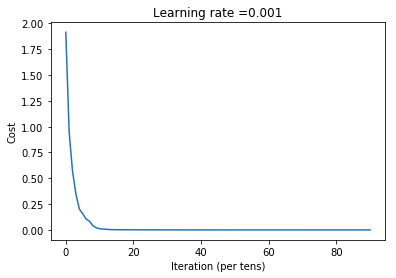

Training data set accuracy: 100.0
Testing data set accuracy: 92.2222


In [13]:
train_accuracy, test_accuracy, parameters = model(x_train_norm, y_train_encoded, x_test_norm, y_test_encoded, num_epochs=91, minibatch_size=75, learning_rate = 0.001, kb=0.8)